In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

import cv2
import re
from tqdm import tqdm

In [3]:
sns.set(style='whitegrid')

# 1. Data reading and split

In [4]:
img_size= 100

In [5]:
#read train
path = "train/"
regex = re.compile('(.*?)(_[0-9])') #for label extraction from file name
x, y = [], []
for p in tqdm(os.listdir(path)):
    category = re.findall(regex, p)[0][0]
    img_array = cv2.imread(os.path.join(path,p))
    new_img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
    new_img_array = cv2.resize(new_img_array, dsize=(img_size, img_size))
    x.append(new_img_array)
    y.append(category)

100%|██████████| 2225/2225 [00:04<00:00, 484.70it/s]


In [6]:
 #reshape de la forma (Batch size, Height, Width, Channels(colores, 1=escala de grises|3=rgb))
x = np.array(x).reshape(-1, img_size,img_size,3)
y =  np.array(y)
x.shape, y.shape

((2225, 100, 100, 3), (2225,))

# 2. Normalización

In [7]:
x = x.astype('float32') / 255

# 3. Data split y label encoder

In [8]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(y)
y = le.transform(y) 

In [9]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)
x_train.shape, x_val.shape, y_train.shape, y_val.shape

((1780, 100, 100, 3), (445, 100, 100, 3), (1780,), (445,))

# 4. Baseline

In [10]:
import keras
from keras.models import Model, Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, GlobalAvgPool2D, GlobalMaxPool2D, Dropout, BatchNormalization, concatenate, Layer, Input
from keras.regularizers import l2
from keras.optimizers import SGD
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers
from keras.callbacks import LearningRateScheduler

/home/gbustamante/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [11]:
model = Sequential() #definir un modelo sequencial

model.add(Conv2D(filters=64, kernel_size=(2,2), activation = 'relu', input_shape =(img_size, img_size, 3))) 
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(filters=64, kernel_size=(2,2), activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(filters=32,kernel_size=(2,2), activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.5))

model.add(Flatten()) 
model.add(Dense(32, activation='relu'))

# Softmax layer | 10 (por el número de clases a predecir)
model.add(Dense(10, activation='sigmoid'))

epochs = 30 #Número de épocas a entrenar
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 99, 99, 64)        832       
_________________________________________________________________
batch_normalization_1 (Batch (None, 99, 99, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 49, 49, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 49, 49, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 64)        16448     
_________________________________________________________________
batch_normalization_2 (Batch (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 24, 24, 64)        0         
__________

In [ ]:
history = model.fit(x_train, y_train, epochs=30, batch_size=32, validation_data=(x_val, y_val), shuffle=True)

Train on 1780 samples, validate on 445 samples
Epoch 1/30
1780/1780 [==============================] - 43s 24ms/step - loss: 2.2880 - acc: 0.1275 - val_loss: 2.8293 - val_acc: 0.1573
Epoch 2/30
1780/1780 [==============================] - 44s 25ms/step - loss: 2.2680 - acc: 0.1652 - val_loss: 2.5337 - val_acc: 0.1191
Epoch 3/30
1780/1780 [==============================] - 44s 24ms/step - loss: 2.2299 - acc: 0.1680 - val_loss: 2.3731 - val_acc: 0.1865
Epoch 4/30
1780/1780 [==============================] - 44s 25ms/step - loss: 2.1651 - acc: 0.1944 - val_loss: 2.8779 - val_acc: 0.1618
Epoch 5/30
1780/1780 [==============================] - 44s 25ms/step - loss: 2.0708 - acc: 0.2112 - val_loss: 2.5750 - val_acc: 0.2270
Epoch 6/30
1780/1780 [==============================] - 44s 25ms/step - loss: 1.9971 - acc: 0.2163 - val_loss: 2.0447 - val_acc: 0.2517
Epoch 7/30
1780/1780 [==============================] - 43s 24ms/step - loss: 1.8973 - acc: 0.2708 - val_loss: 2.1447 - val_acc: 0.2831
E

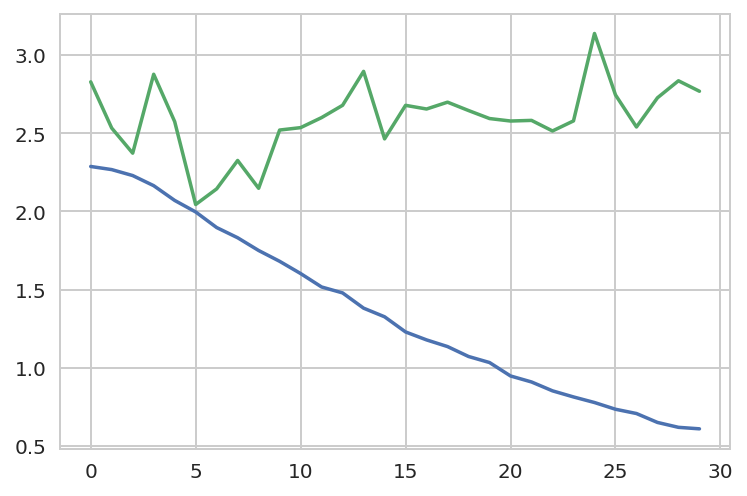

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

# 5. Evaluación

In [15]:
#leer el test
#read train
path = "test/"
x_test = []
test_names = []
for p in tqdm(os.listdir(path)):
    test_names.append(p)
    img_array = cv2.imread(os.path.join(path,p))
    new_img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
    new_img_array = cv2.resize(new_img_array, dsize=(img_size, img_size))
    x_test.append(new_img_array)

100%|██████████| 530/530 [00:01<00:00, 461.82it/s]


In [16]:
x_test = np.array(x_test).reshape(-1, img_size,img_size,3)
x_test.shape

(530, 100, 100, 3)

In [17]:
x_test = x_test.astype('float32') / 255

In [18]:
y_pred = model.predict_classes(x_test)

In [24]:
#save solution file
data = {'file': test_names, 'label': le.inverse_transform(y_pred)}
df_sub = pd.DataFrame(data)
df_sub = df_sub.sort_values(by='file')
df_sub.to_csv('submission1.csv', index=False)

# 6. Transfer Learning

In [25]:
from keras.applications.resnet50 import ResNet50

In [26]:
#Cargamos la red pre entrenada ResNet50
base_model = ResNet50(include_top=False, input_shape=(img_size,img_size,3), pooling='avg')
# No queremos actualizar los pesos
base_model.trainable = False 
# Información sobre la red
base_model.input, base_model.output

94658560/94653016 [==============================] - 22s 0us/step


(<tf.Tensor 'input_1:0' shape=(?, 100, 100, 3) dtype=float32>,
 <tf.Tensor 'global_average_pooling2d_1/Mean:0' shape=(?, 2048) dtype=float32>)

In [35]:
# Capas densas a agregar encima de la red pre-entrenada
model = Sequential()
#==================================================
# Fully Connected layer
#==================================================
model.add(Dense(512, activation='relu', input_shape=(2048,)))
model.add(Dropout(0.5)) 
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5)) 
#==================================================
# Capa final
#==================================================
model.add(Dense(10, activation='softmax')) 

model.compile(optimizer="adam", loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 512)               1049088   
_________________________________________________________________
dropout_9 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 128)               65664     
_________________________________________________________________
dropout_10 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 10)                1290      
Total params: 1,116,042
Trainable params: 1,116,042
Non-trainable params: 0
_________________________________________________________________


In [28]:
# Obtenemos los output de la red pre entrenada que servirán de input para nuestro modelo
precomputed_train = base_model.predict(x_train, batch_size=128, verbose=1)
print(precomputed_train.shape)
precomputed_val = base_model.predict(x_val, batch_size=128, verbose=1)
print(precomputed_val.shape)

1780/1780 [==============================] - 26s 15ms/step
(1780, 2048)
445/445 [==============================] - 6s 14ms/step
(445, 2048)


In [ ]:
log = model.fit(precomputed_train, y_train, epochs=200, batch_size=32, validation_data=(precomputed_val, y_val), shuffle=True)

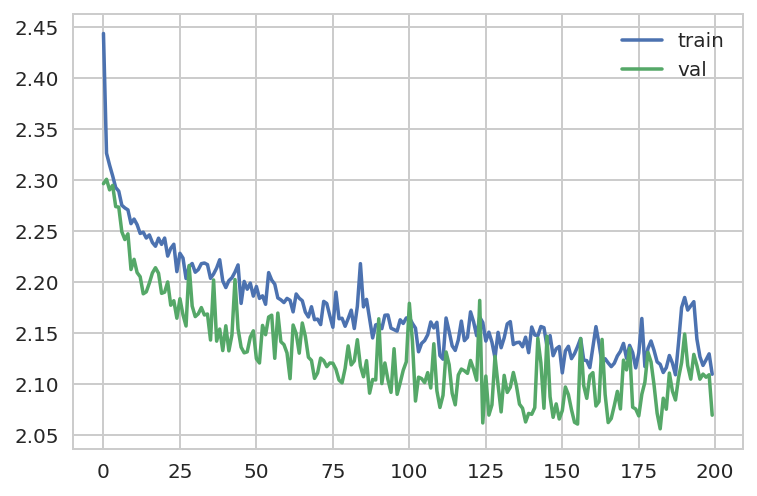

In [37]:
plt.plot(log.history['loss'], label='train')
plt.plot(log.history['val_loss'], label='val')
plt.legend()

:)

In [38]:
precomputed_test = base_model.predict(x_test, batch_size=128, verbose=1)
print(precomputed_test.shape)

530/530 [==============================] - 7s 14ms/step
(530, 2048)


In [39]:
y_pred = model.predict_classes(precomputed_test)

In [40]:
#save solution file
data = {'file': test_names, 'label': le.inverse_transform(y_pred)}
df_sub = pd.DataFrame(data)
df_sub = df_sub.sort_values(by='file')
df_sub.to_csv('submission2.csv', index=False)